*Francisco Pereira [camara@dtu.dk], DTU Management*

*Stanislav Borysov [stabo@dtu.dk], DTU Management*

# Advanced Business Analytics

## Lecture 2 - Text Analytics - Part 1: Spam Classification

Given that language remains a primary means of communication between humans, a lot of extremely useful data come in a natural language form. However, given its complexity and ambiguity, representing these data in a suitable form for automatic processing is a very difficult research challenge. In this exercise, we will get familiar with some basic text analysis techniques. As an exercise, we will try to classify SMS messages for spam detection. The data was downloaded from http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/

### 1. Descriptive data analysis

As usual in data science, we will start with descriptive data analysis to understand the data structure and get useful insights. Load the data from `smsspamcollection/SMSSpamCollection.txt` and print the number of spam and non-spam ("ham") messages.

In [17]:
import pandas as pd
import numpy as np

In [23]:
data_df = pd.read_csv("smsspamcollection/SMSSpamCollection.txt", 
                      sep="\t", 
                      header=None,
                      names=['type', 'message'])



In [24]:
data_df.head()

,type,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [27]:
print('Total message:',len(data_df))
print('Spam message:',len(data_df[data_df['type']=='spam']))
print('Non-spam messgae:',len(data_df[data_df['type']=='ham']))

Total message: 5572
Spam message: 747
Non-spam messgae: 4825


Note that the data is imbalanced, which is very common in such types of problems. Now, plot the histogram of message lengths and print average message length for each of the two message types ("ham" and "spam").

In [30]:
#we will do the first part for you, of creating a new column with message lengths :-)
data_df['message_len'] = data_df['message'].apply(len)
data_df['message_len']

0       111
1        29
2       155
3        49
4        61
       ... 
5567    160
5568     36
5569     57
5570    125
5571     26
Name: message_len, Length: 5572, dtype: int64

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

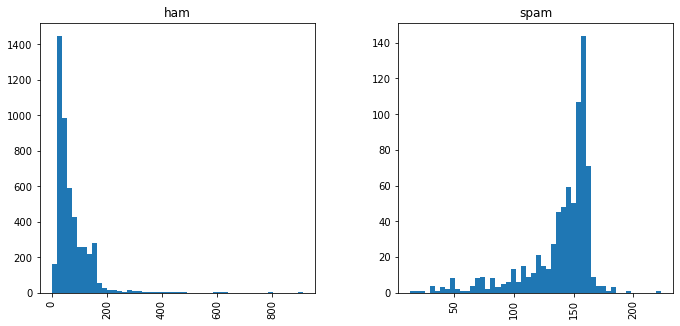

In [44]:
data_df.hist(column='message_len', by='type', bins=50,figsize=(11,5));

The very first insight: The spam messages tend to be longer! It might be a useful feature in our classification problem. Let's visualize the most popular words for each category using word clouds. You can use either the `wordcloud` Python package or some external websites such as https://www.wordclouds.com/

In [45]:
import wordcloud

def show_wordcloud(data_spam_or_ham, title):
    text = ' '.join(data_spam_or_ham['message'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,
        max_font_size=100, max_words=100, background_color="white").generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud, interpolation="bilinear")  
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

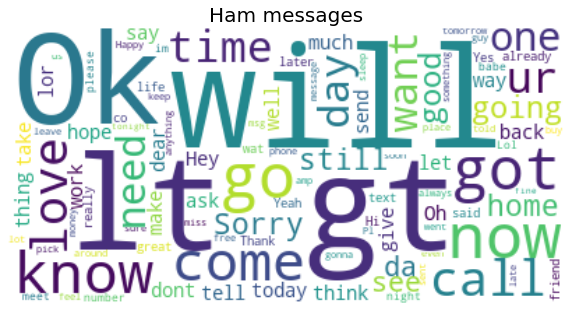

In [46]:
# word cloud of ham messages
show_wordcloud(data_df[data_df.type=='ham'], "Ham messages")

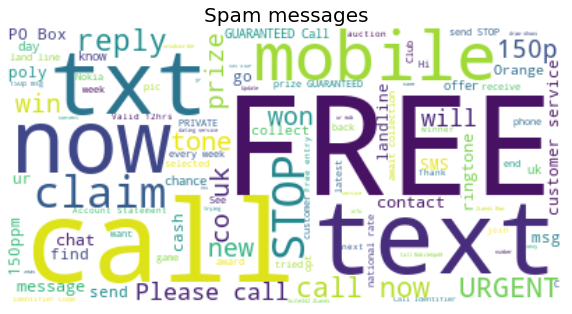

In [47]:
# word cloud of spam messages
show_wordcloud(data_df[data_df.type=='spam'], "Spam messages")

These word clouds suggest that using words as features for our classification problem can be a not bad idea.

### 2. Text preprocessing

First, we need to do some text preprocessing, commonly referred to as "normalization". Text preprocessing is usually the most crucial and time-consuming part of the NLP pipeline. In this exercise, it will include the following simple steps:

1. Removing punctuation
2. Converting text to lowercase *(Side note: This step is questionable since spammers tend to use more uppercase letters)*
3. Removing stopwords (either using a predefined list of the English stopwords or using the most frequent words in the text directly)
4. (Optional) Stemming or lemmatizing

This list is, of course, is incomplete and other steps can also include removing rare words, removing numbers, synonymizing, handling negation, etc.

In Python, there are many NLP packages available, such as `NLTK` (the most popular one), `Gensim`, or `spaCy`, however, we will mostly use the basic functionality provided by `sklearn`. For stemming or lemmatizing, one can use the `NLTK` library.

*Side note: In principle, all preprocessing should be done on the train and test sets separately. However, we will skip this **only** for simplicity.*

In [1]:
from stopwords import get_stopwords
import string
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

stop_words=get_stopwords('en')

In [2]:
def text_processing(text):
    # remove punctuation 
    text = "".join([c for c in text 
                    if c not in string.punctuation])
    # lowercase
    text = "".join([c.lower() for c in text])
    # remove stopwords
    text = " ".join([w for w in text.split() 
                     if w not in stop_words])
    # stemming / lematizing (optional)
    text = " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    return text

In [13]:
data_df['message_clean'] = data_df['message'].apply(text_processing)

Print a few messages to check how the preprocessed messages differ from the raw ones.

In [20]:
#...

Let's now represent the text in a format which can be used in machine learning. Since we will use a vector format for the messages ("documents"), this process is called "vectorization". We will use a simple "bag-of-words" (BoW) representation on a single word level (1-grams). First, let's do simple word counts, where `sklearn.feature_extraction.text.CountVectorizer` can be particularly useful. Such vectorizers convert the whole corpora to a document-term matrix of size $N\times M$, where $N$ is a number of documents (messages), $M$ is a vocabulary size (number of different words in the corpora), and each element $d_{ij}$ corresponds to the number (or frequency, or tf-idf, etc) of the word $j$ in the document $i$. Since each document is usually far from containing all the words from vocabulary, the matrix is usually very sparse (has a lot of 0's).

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
bow_counts = count_vect.fit_transform(data_df['message_clean'].values)
print(bow_counts[0])

  (0, 4406)	1
  (0, 6007)	1
  (0, 2373)	1
  (0, 1371)	1
  (0, 1803)	1
  (0, 3651)	1
  (0, 8542)	1
  (0, 4559)	1
  (0, 1801)	1
  (0, 2112)	1
  (0, 3613)	1
  (0, 1155)	1
  (0, 8329)	1


Now the vocabulary is all contained in a dictionary called count_vect.vocabulary_. Check it, print its size. It should be close to 9000 (this is a huge number of features!).

In [22]:
#...

It is often useful to also create the inverse mapping of the vocabulary_. The inverse mapping (let's call it **index_to_word**), is a dictionary where the keys are the indexes, and the values are the words) 

In [23]:
#...

Now let's weight the term frequencies by inverse document frequency (tf-idf representation). 

*Hint: `sklearn` has this functionality as well, check `sklearn.feature_extraction.text.TfidfTransformer`*

In [24]:
#...

Just to get an idea of the TFIDF results, you could print, for each message, which word has the highest TFIDF value. 

You want the output to look something like:

```
amore --> jurong point crazy available bugis n great world la e buffet cine got amore wat
oni --> ok lar joking wif u oni
fa --> free entry 2 wkly comp win fa cup final tkts 21st 2005 text fa 87121 receive entry questionstd txt ratetcs apply 08452810075over18s
say --> u dun say early hor u c say
nah --> nah dont think go usf life```


In [25]:
#...

Having our text normalized and vectorized, let's finally proceed to machine learning!

### 3. Classification

To classify messages as spam/ham (binary classification), we will compare three different sets of features: 
1. Length of messages only
2. Term frequencies (counts)
3. Tf-idf

We will also compare these classifiers to a naive baseline which predicts the most frequent class. Before starting, let us make sure that we have all the features and the target labels ready for the modelling.

In [128]:
X_len = data_df['message_len'].values
X_len = X_len.reshape(-1, 1) # Since we it is single feature
X_bow_counts = bow_counts
X_bow_tfidf = bow_tfidf
y = data_df['type'].apply(lambda x: 1 if x == 'spam' else 0).values
labels = np.array(['ham', 'spam'])

In [129]:
print(X_len.shape)
print(X_bow_counts.shape)
print(X_bow_tfidf.shape)
print(y.shape)

(5572, 1)
(5572, 8788)
(5572, 8788)
(5572,)


We will use 80%/20% train/test split. Note that as the data is imbalanced, this split should be stratified, i.e., the proportion of spam messages in the test set should be the same as in the whole dataset.

In [130]:
# train/test split
from sklearn.model_selection import train_test_split

rs = 42 # reproducible results, set to None for random
(X_len_train, X_len_test, X_bow_counts_train, X_bow_counts_test, 
 X_bow_tfidf_train, X_bow_tfidf_test, y_train, y_test) = train_test_split(
    X_len, X_bow_counts, X_bow_tfidf, y,
    test_size=0.2, stratify=y, random_state=rs)

Check if the proportion of the spam messages is the same in the test set and the whole dataset.

In [26]:
#...

**Naive baseline**

Always start with the simplest baseline, for example, predicting the most frequent class in the training set. Use standard performance metrics such as confusion matrix and F1 score.

In [28]:
#...

In [29]:
#...

**Classification using the message length only**

Train classifier which uses the message length as the only feature. Use your favorite model (e.g. Logistic Regression, Support Vector Machine or Neural Net). Remember which implications the data imbalance might have for the model training (e.g., set `class_weight='balanced'` for `sklearn.linear_model.LogisticRegression`). Use standard performance metrics such as confusion matrix and F1 score.

*Optional: If you want, you can balance the training set directly, for instance, using upsampling or downsampling.*

*Optional: You can also tune hyperparameters (e.g. `C` in `sklearn.linear_model.LogisticRegression`), for example, using grid search on the training set based on cross-validation.*

In [30]:
#...

In [31]:
#...

**Classification using term frequencies (counts)**

Train classifier which uses the term frequencies as features. Use standard performance metrics such as confusion matrix and F1 score.

In [32]:
#...

**Classification using tf-idf matrix**

Train classifier which uses the tf-idf matrix as features. Use standard performance metrics such as confusion matrix and F1 score.

In [33]:
#...

Which model performs better? Discuss your results with another student.

One common treatment (but not at all the only one!) an unbalanced dataset is to upsample the lower sample classe(s). Below is a code that you can try. 

### 4. Topic modeling

Topic modeling is a useful set of techniques to represent a document as a set of concepts (or "topics"). Conceptually, it is similar to eigenvector decomposition (Principal Component Analysis, PCA), when each data point (document) is represented as a weighted sum of different eigenvectors (topics). Topics and decompositions are learned by the algorithm in an unsupervised manner. We will use the most popular one -- Latent Dirichlet Allocation (LDA). There are many implementations of the LDA algorithm in different languages and libraries, including `sklearn`.

In [34]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 7  #this is the important K value that you need to decide
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

Let's run the LDA algorithm. Note that it is designed to take term frequency matrix (counts) as an input, however, it is possible to run on tf-idf matrix as well.

In [151]:
X_lda_train = lda.fit_transform(X_bow_counts_train)

Print top N words together with their weights in each topic

In [152]:
#...


Do they have any meaning? Discuss with another student. Try to experiment with different numbers of topics and see how it affects their interpretability.


**Classification using LDA**

Train classifier which uses topic weights for each document (message) as features for the case `n_topics = 7`. Use standard performance metrics such as confusion matrix and F1 score.

In [35]:
#...

In [36]:
#...

Not bad! You can get very good performance using only a small number of features for each message instead of thousands of words!

Finally, plot the classification performance for different numbers of topics. Also, inspect topics for the best performing model.

*Note: The topics number is itself a hyperparameter, which should be tuned using the training set only (e.g. using a 3-way CV). However, as LDA can be computationally demanding, we will skip this part and calculate the performance for the different number of topics directly on the test set.*

In [38]:
#...

In [37]:
#...